# Techniques of High Performance Computing - Assignment 1

- Student Name: John Duffy
- Student Number: 19154676

# Question 1

### A program to simulate random walks.

#### Program Description

A particle is positioned at each of the (x, y) coordinates of a N x N lattice grid.
M simualtions are carried out to determine the probability of each particle reaching
the bottom boundary of the grid during a random walk of up to S steps.

This is a compute bound problem, as there is no data shared between simulations.
The result of each simualtion is independent and the result is success (if the bottom
boundary is reached) or failure (if any other boundary is reached, or S steps are
completed without a boundary being reached). A data structure is used to count the
number of successes, which is subsequently turned into a probability.

This is an integer problem. The random walks are implemented as a single integer
step up, down, left or right. And the success counts are integer. Therefore, to avoid
floating point overhead, as much as possible is done using integer data
structures (which also results in a memory saving) and integer operations. A floating
point data sructure is used at the end of the program to store the probabilties.

Numpy arrays are used at the outset as the data structure to store the random walk
success counts (an integer array) and the resulting probabilities (a float array). 
Matplotlib is then used to display the probabilities.

#### Program Structure Optimisation

Because this is a compute bound problem, the structure of the program was consisdered
carefully to ensure function calls and repeated operations are minimised. Function/library
calls considered likely to be expensive, e.g. numpy.random.ranint(), are done once outside
of a loop rather than multiple times inside a loop.

#### Pre Optimisation Results

Using only Numpy the following baseline results were obtained:

* M: 1000
* N: 50
* S: N * N

* Time: 689 seconds

* CPU Load: 13%


##### 2019-10-19_Refinement_1

The important thing is that each grid position is exposed to M independent random walks. It
not important that each grid position is exposed to different M independent random walks.
So, rather compute S random walk steps for each grid position for each simulation (M * N * N
calls to numpy.random.randint()), we can compute S random walk steps for each simulation and
apply the same steps to each grid position (M calls to numpy.random.randint()). A saving of
a factor of N * N calls to numpy.random.randint(). This also has the added benefit of moving
the numpy.random.randint() call out of the random_walk() function making it easier to
further optimise this function. The S random walk steps are now passed into random_walk() as
a parameter.

* M: 1000
* N: 50
* S: N * N

* Time: 677 seconds. Eh? Surprising and disappointing! Passing steps array problematic?

* CPU Load: 13%

#### Optimisation Results

##### 2019-10-19_Refinement_1

Added @njit decorator to random_walk() function.

* M: 1000
* N: 50
* S: N * N

* Time: 5.2 seconds

* CPU Load: 13%


#### Import required libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

from numba import njit, prange

In [3]:
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start


Define global variables

In [4]:
# Number of trials. The same number of trials is conducted for each grid point.

M = 1000

# Grid size, N x N

N = 50

# The maximum number of random walk steps.

S = N * N  # TODO: Sensible?


Define Numpy arrays to store the number of trial successes (particle hits bottom boundary), and subsequently the probability of success.


In [5]:
# Successes are integers, so use uint32 to save some memory and minimise cache misses. 

successes  = np.zeros((N, N), dtype='uint32')

# Probabilities are calculated at the end of the program to avoid floating point overhead.

probabilities = np.zeros((N, N))


In [6]:
print(successes)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [7]:
@njit
def random_walk(x, y, steps):
    """
    This function takes as input the (x, y) position of a particle on an N x N grid, and then
    takes up to S random walk steps up, down, left or right. The function returns True if the
    bottom boundary is reached, or the bottom boundary is the initial position. The function
    returns False if S steps are taken and no boundary is reached, or as soon as the
    top, left or right boundarie are reached.
    
    The intention is to Just in Time compile this function using Numba/njit, so make this code
    as simple 'C' like as possible.
    """
 
    # Parameter sanity checks...
    
    assert x >= 1 and x <= N, "x bound error"
    assert y >= 1 and y <= N, "y bound error"
    
 
    # If the intial position of the particle is on a boundary, no need to start a random walk.
    # The order of tests selected to return True as soon as possible.
    
    if y == 1: return True  # Bottom   
    if y == N: return False # Top    
    if x == 1: return False # Left    
    if x == N: return False # Right
    

    # Store initial (x, y) position...
    
    new_x = x
    new_y = y
    

    # Start the random walk with the step directions defined as...

    # 0 == down
    # 1 == up
    # 2 == left
    # 3 == right
   
    for s in range(S):

        # Take a step, and test for a boundary conditions as soon as possible...

        if steps[s] == 0:
            new_y -= 1
            if new_y == 1:
                return True

        if steps[s] == 1:
            new_y += 1
            if new_y == N:
                return False
            
        if steps[s] == 2:
            new_x -= 1
            if new_x == 1:
                return False

        if steps[s] == 3:
            new_x += 1
            if new_x == N:
                return False
    

    # Boundary not reached...
    
    return False


In [8]:
# Run M random walk simualtions on each (x, y) grid position.

# NB We are using (1..N, 1..N) as (x, y) coordinates in a Cartesian sense, but Numpy
# uses [row, column] starting in the top left. So, some jiggery pokery is
# required to make the Numpy array look like a Cartesian array.


with Timer() as t:
    
    for m in range(M):
        
        steps = np.random.randint(4, size = S)
        
        for x in range (1, N + 1):
            for y in range (1, N + 1):
                if random_walk(x, y, steps):
                    successes[x - 1, y - 1] += 1
                
    probabilities = successes / M

print("Total time: {0}".format(t.interval))


Total time: 5.361231803894043


In [9]:
print(probabilities)


[[1.    0.    0.    ... 0.    0.    0.   ]
 [1.    0.52  0.331 ... 0.    0.    0.   ]
 [1.    0.709 0.528 ... 0.    0.    0.   ]
 ...
 [1.    0.689 0.507 ... 0.002 0.001 0.   ]
 [1.    0.495 0.313 ... 0.001 0.001 0.   ]
 [1.    0.    0.    ... 0.    0.    0.   ]]


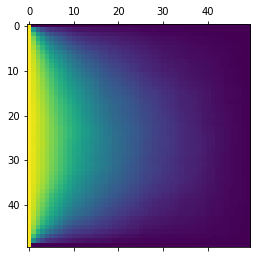

In [10]:
plt.matshow(probabilities)


# Question 2

In [84]:
R = 8 # Radius 1 < r < 10

M = 360

N = 1


In [85]:
evaluation_positions = np.zeros((R, M), dtype='complex64')

for r in range(R):
    for m in range(M):
        evaluation_positions[r, m] = (2. + r) * np.exp(1j * 2. * np.pi / M * m)


In [86]:
charge_positions = np.zeros((N), dtype='complex64')

charge_positions[0] = 0. * np.exp(1j * 0)

print(charge_positions)


[0.+0.j]


In [87]:
potential_sums = np.zeros((R, M))

for r in range(R):
    for m in range(M):
        for n in range(N):
            potential_sums[r, m] += np.linalg.norm(evaluation_positions[r, m] - charge_positions[n])

print(potential_sums)


[[2.         2.         2.         ... 2.         2.         2.        ]
 [3.         3.         3.         ... 3.00000024 3.         3.        ]
 [4.         4.         4.         ... 4.         4.         4.        ]
 ...
 [7.         6.99999952 7.         ... 6.99999952 7.         6.99999952]
 [8.         8.         8.         ... 8.         8.         8.        ]
 [9.         9.         9.         ... 9.         9.         9.        ]]


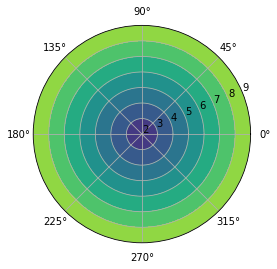

In [88]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(111, projection='polar')

ax.contourf(np.angle(evaluation_positions), np.absolute(evaluation_positions), potential_sums)

#for r in range(R):
#    ax.scatter(np.angle(evaluation_positions[r]), np.absolute(evaluation_positions[r]))

plt.show()